In [1]:
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from utils.calculate_pmi_features import get_data
from utils.textnormalization import split_on_word, normalize
from utils.happyfuntokenizing import Tokenizer

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
mpl.rc('savefig', dpi=200)
params = {'figure.dpi' : 200,
          'axes.axisbelow' : True,
          'lines.antialiased' : True}

for (k, v) in params.items():
    plt.rcParams[k] = v

In [3]:
def sentences(s_list):
    words = split_on_word(s_list)
    words_norm = normalize(words)
    return [' '.join(s) for s in words_norm]

In [4]:
df = get_data()

In [5]:
TAG_RE = re.compile(r'<[^>]+>')

essays = ['essay' + str(i) for i in range(10)]
for e in essays:
    df[e] = df[e].replace(np.nan, '' , regex=True)    \
                 .replace('\n', ' ')                  \
                 .apply(lambda x: TAG_RE.sub(' ', x)) \
                 .apply(lambda x: re.sub('\s+', ' ', x).strip())

df.fillna('', inplace=True)
df['ethnicity_'] = df.ethnicity.apply(lambda x: 'multi' if ',' in x else x)
df['token_count'] = df.TotalEssays.str.split().str.len()

In [6]:
df_token_threshold = df[df.token_count >= 100]
df_token_threshold.reset_index(drop=True, inplace=True)

In [7]:
essay = 'essay4'

In [8]:
sents = sentences(df_token_threshold[essay].tolist())

In [9]:
tfidf = TfidfVectorizer(stop_words='english',
                        tokenizer=Tokenizer().tokenize,
                        sublinear_tf=True,
                        min_df=0.01, max_df=0.5)
data = tfidf.fit_transform(sents)

## NMF

In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
    print()

In [11]:
K = 20

ed = []
for k in range(2, K+1):
    nmf = NMF(n_components=k, random_state=1).fit(data)
    W = nmf.components_
    ed.append(np.tril(cosine_similarity(W, W), k=-1).mean())

In [12]:
z = np.polyfit(np.array(range(2, K+1)), np.array(ed), 3)
p = np.poly1d(z)
v = [p(v) for v in range(2, K+1)]

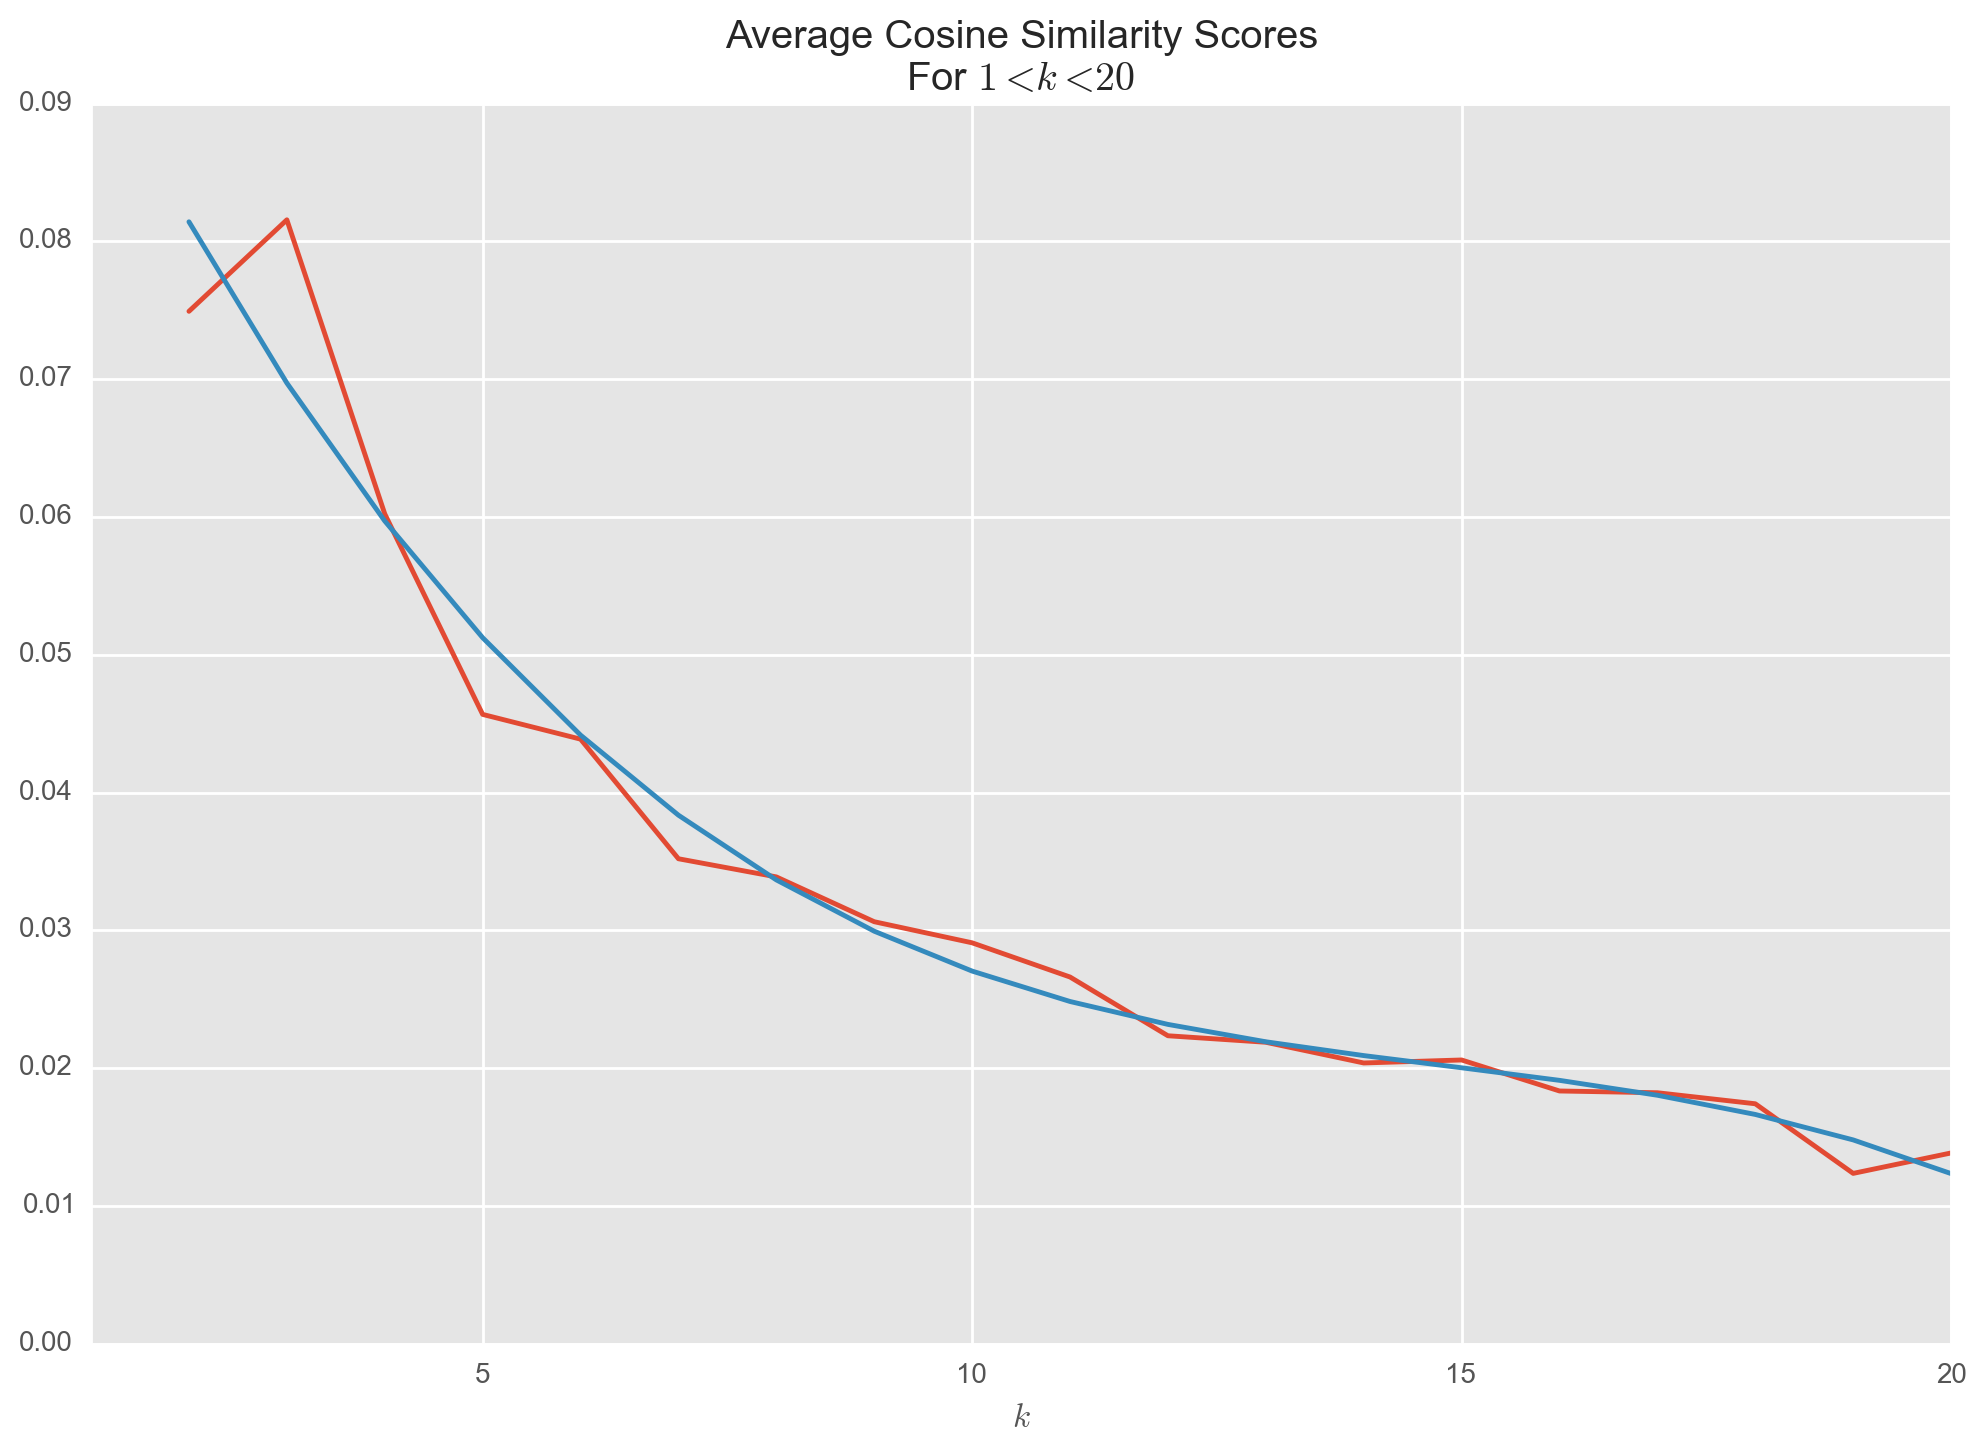

In [13]:
plt.figure(figsize=(12, 8))

plt.plot(range(2, K+1), ed)
plt.plot(range(2, K+1), v)

plt.xlim(1);
plt.ylim(0);

plt.title('Average Cosine Similarity Scores\nFor $1 < k < %s$' % K)
plt.xlabel('$k$')

In [14]:
n_topics = 15
n_top_words = 25

In [15]:
tfidf_feature_names = tfidf.get_feature_names()

In [16]:
nmf = NMF(n_components=n_topics, random_state=1).fit(data)

In [17]:
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
good enjoy new great really live things cooking especially long taste ones films trying world tastes wine restaurants dance make variety favorites hunting life reading

Topic #1:
harry potter series star lord rings books game wars games hunger trilogy thrones trek dark girl ender's dragon princess matrix bride ice tattoo fantasy firefly

Topic #2:
rock hop hip jazz classic country classical rap pop reggae alternative old blues indie metal punk soul school listen folk funk house electronic hip-hop dance

Topic #3:
like kinds things stuff different lot kind types really especially books foods lots try people funny comedies variety feel ones yes tend make bands dont

Topic #4:
i'm reading list i've it's fan right i'll pretty currently big way favorites listening long open huge going try think things new say time probably

Topic #5:
... .... list know books yes ask say goes ..... long lol that's lots way hard little come start right course let's later can't talk

Topic #6:
italia

In [18]:
W = nmf.components_
H = nmf.fit_transform(data)

In [19]:
W.shape

(15, 982)

In [20]:
H.shape

(50827, 15)

In [21]:
labels = np.argmax(H, axis=1)

In [22]:
print('Distribution of Samples by Cluster (Topic)')
pd.DataFrame(labels)[0].value_counts().sort_index()

Distribution of Samples by Cluster (Topic)


0     7349
1     4308
2     4721
3     3066
4     4363
5     3859
6     3374
7     1743
8     2134
9     2953
10    2522
11    2115
12    1286
13    2075
14    4959
dtype: int64

In [23]:
df_token_threshold['labels'] = labels

In [24]:
print('Average Token Count by Cluster (Topic)')
df_token_threshold.groupby('labels')['token_count'].mean()

Average Token Count by Cluster (Topic)


labels
0     325.995510
1     458.896936
2     417.164372
3     391.023810
4     533.404997
5     415.555325
6     386.550978
7     376.808376
8     428.648547
9     354.337961
10    346.306899
11    400.972104
12    318.185070
13    501.237590
14    494.581972
Name: token_count, dtype: float64

In [25]:
for c in np.sort(df_token_threshold['labels'].unique()):
    if c == 0:
        tdf = df_token_threshold[df_token_threshold['labels'] == c]
        tdf_p = pd.DataFrame({str(c) :
                              tdf.ethnicity_.value_counts().sort_index()/\
                              tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index()
    else:
        tdf = df_token_threshold[df_token_threshold['labels'] == c]
        tdf_p = pd.merge(tdf_p,
                         pd.DataFrame({str(c) :
                                       tdf.ethnicity_.value_counts().sort_index()/\
                                       tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index(),
                         how='outer',
                         on='index')

tdf_p.fillna(0)
tdf_p.rename(columns={'index':'ethnicity_'}, inplace=True)

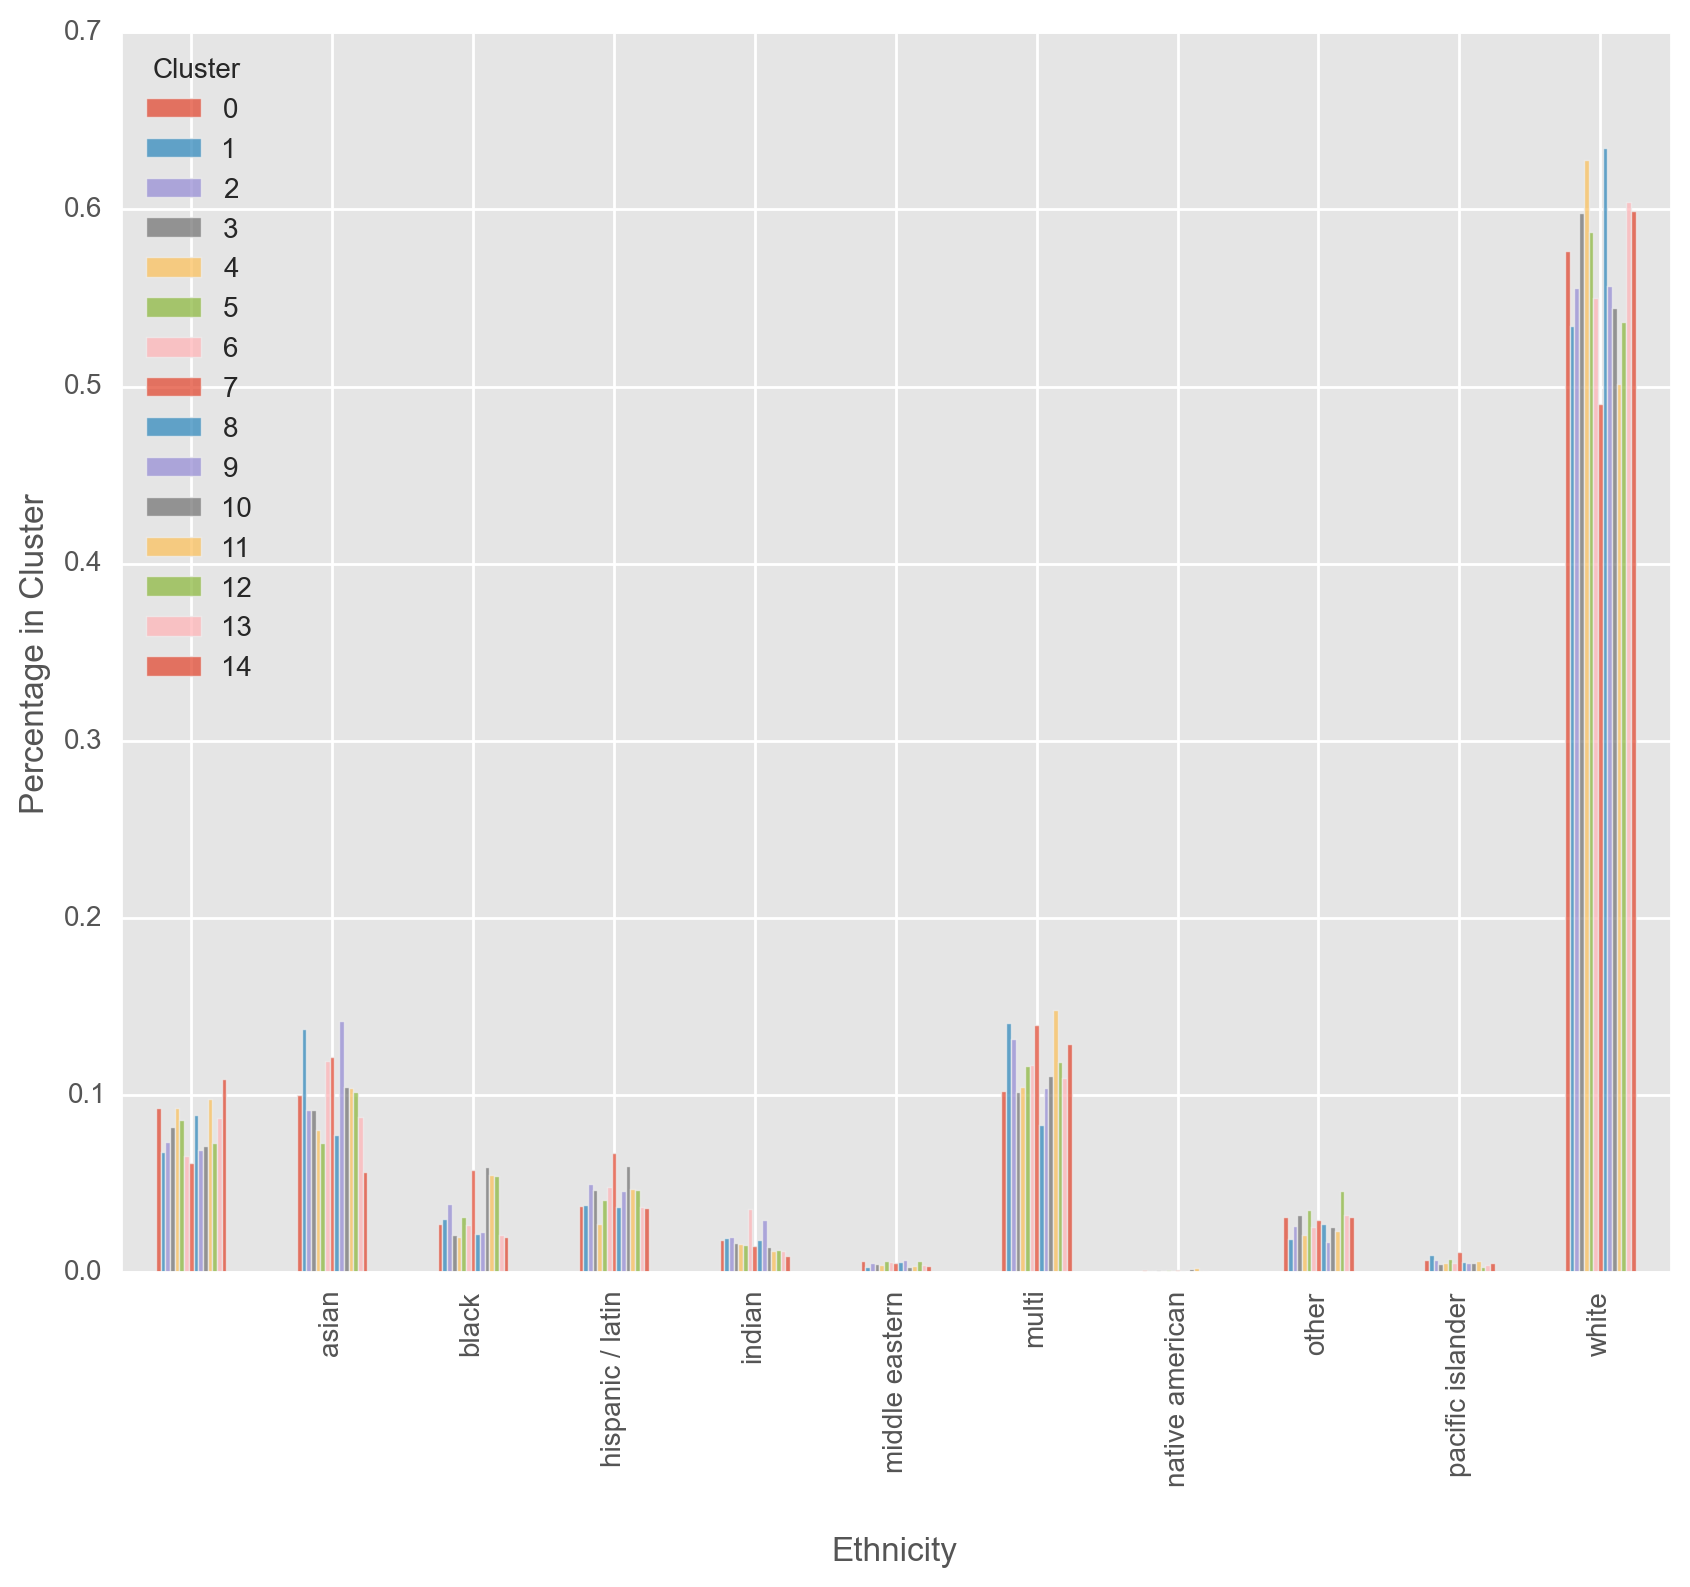

In [26]:
tdf_p.plot(alpha=0.75, figsize=(10, 8), kind='bar')

plt.xlim(-0.5, len(df_token_threshold.ethnicity_.unique())-0.5)
plt.xticks(tdf_p.index, tdf_p.ethnicity_, rotation=90);

plt.xlabel('\nEthnicity')
plt.ylabel('Percentage in Cluster')

plt.legend(range(n_topics), loc='upper left', title='Cluster')